In [23]:
import torchvision as tv
import cv2 as cv
import torch
from tools import *
from torch import nn
from torch.nn import Conv2d, Linear, Sigmoid, UpsamplingBilinear2d
from torch.optim import SGD, lr_scheduler

In [24]:
model1 = tv.models.vgg16(pretrained = True).features
s = 0
a = []
for i in model1:
    if isinstance(i,Conv2d):
        a.append(s)
        i.weight.requires_grad_(False)
        i.bias.requires_grad_(False)
    s+=1

In [25]:
def feature_map(img,num):
    return model1[:a[num]+1](img)

In [26]:
def Gram(img, num):
    feature_maps = feature_map(img,num)[0]
    m, n = feature_maps.shape[1], feature_maps.shape[2]
    feature_maps = feature_maps.view(feature_maps.shape[0],-1)
    return torch.mm(feature_maps,feature_maps.transpose(1,0)),m,n

In [27]:
class model(nn.Module):
    def __init__(self):
        super(model,self).__init__()
        self.fc = Linear(1000, 10000*3)
        self.conv = nn.Sequential(
            UpsamplingBilinear2d(scale_factor=2),
            Conv2d(3,16,5,1,2),
            UpsamplingBilinear2d(scale_factor=2),
            Conv2d(16,3,5,1,2),
            Sigmoid()
        )
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(1,3,100,100)
        y = self.conv(x)
        return y

In [28]:
class Train():
    def __init__(self,
                 lr = 0.01,
                 pretrain = False):
        #self.model = model()
        self.model = Linear(1200,400)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        if pretrain == True:
            load_model(self.model,m=1)
        self.optimizer = SGD(self.model.parameters(),lr = lr)
        lambda1 = lambda epoch : 0.98**epoch
        self.scheduler = lr_scheduler.LambdaLR(self.optimizer,lr_lambda = lambda1)
        self.img_c = torch.Tensor(cv.imread('./c.jpg')/255.).permute(2,0,1).unsqueeze(0).to(self.device)
        self.img_s = torch.Tensor(cv.imread('./s.jpg')/255.).permute(2,0,1).unsqueeze(0).to(self.device)
        
    def train(self, epoch_num, step_a_epoch, save_frq):
        x = torch.ones(1000)
        global_step = 0 
        epoch = 0
        min_loss = 1000
        self.model.train()
        while(epoch<epoch_num):
            for i in range(step_a_epoch):
                loss1 = 0.0
                loss2 = 0.0
                self.optimizer.zero_grad()
                #img = self.model(x)
                img = self.model.weight.view(1,3,400,400)
                for j in range(2,4):
                    logit_cs = feature_map(img, j)
                    logit_c = feature_map(self.img_c, j)
                    loss1 += torch.sum((logit_cs-logit_c)**2)*0.5
                for j in range(len(a)):
                    gram_ss,m,n = Gram(img, j)
                    gram_s,m,n = Gram(self.img_s, j)
                    loss2 += torch.sum((gram_ss-gram_s)**2)/(4*m**2*n**2)
                loss = 0.000001*loss1 + 0.0000001*loss2
                loss.backward()
                self.optimizer.step()
                if global_step%save_frq == 0 and loss<min_loss:
                    min_loss = loss
                    save_model(self.model,self.optimizer, self.scheduler, global_step, m = 1)
                    print('learning rate:    {:6f}'.format(self.scheduler.get_lr()[0]))
                    print('step:    {:}    loss:    {:}'.format(global_step,loss))
                global_step += 1 
            epoch += 1
            self.scheduler.step(epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


模型参数加载成功！


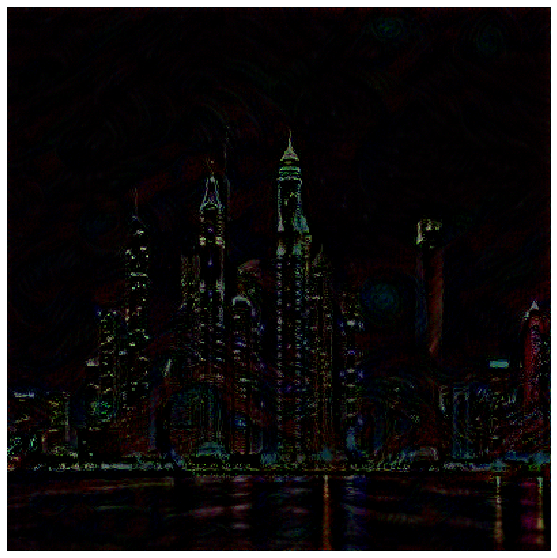

In [29]:
#mo = model()
mo = Linear(1200,400)
load_model(mo,m=1)
x = torch.ones(1000) 
img = mo.weight.view(3,400,400).permute(1,2,0).data
#img = mo(x)[0].permute(1,2,0).data
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()